# UCI Heart Disease Notebook

## 1. Import Libraries and Setup

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer  # 🔧 Added to handle missing values
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Markdown, display

import graphviz
import os

## 2. Data Loading

In [203]:
def load_data():
    """Fetch the Heart Disease dataset from UCI repository."""
    heart_disease = fetch_ucirepo(id=45)
    features = heart_disease.data.features
    targets = heart_disease.data.targets

    # Đổi tên cột target thành "target" nếu chưa đúng
    if targets.shape[1] == 1:
        targets.columns = ["target"]

    df = pd.concat([features, targets], axis=1)
    return df

## 3. Data Preprocessing

In [204]:
def preprocess_data(df):
    """Prepare features and target + create preprocessing pipeline."""
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    numeric_features = numeric_cols.drop("target") if "target" in numeric_cols else numeric_cols
    categorical_features = df.select_dtypes(include=["object", "category"]).columns

    # Added SimpleImputer to handle missing values
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    X = df.drop("target", axis=1)
    y = df["target"]
    y = np.where(y == 0, 0, 1)
    return X, y, preprocessor

## 4. Distribution Plot

In [205]:
def plot_distribution(y, title="Target Distribution"):
    """Plot the distribution of the target labels."""
    # Ensure y is a Pandas Series
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    counts = y.value_counts().sort_index()
    plt.figure(figsize=(5, 3))
    plt.bar(counts.index.astype(str), counts.values, color="skyblue")
    plt.title(title)
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 5. Building the Model Pipeline

In [206]:

def build_pipeline(preprocessor, max_depth=None):
    """Construct a pipeline with preprocessing and decision tree."""
    return Pipeline([
        ("preprocess", preprocessor),
        ("classifier", DecisionTreeClassifier(
            max_depth=max_depth, 
            random_state=42,
            criterion='entropy'  # Đề bài yêu cầu information gain
        ))
    ])

## 6. Training the Decision Tree Model

In [207]:
def train_model(pipeline, X_train, y_train):
    """Fit the pipeline to training data."""
    pipeline.fit(X_train, y_train.ravel())  # ravel for compatibility with single-column y
    return pipeline

## 7. Evaluating the Model Performance

In [208]:
def evaluate_model(clf, X_test, y_test, title_prefix=""):
    """Evaluate classifier and visualize results."""
    y_pred = clf.predict(X_test)
    display(Markdown(f"### 📊 {title_prefix} Classification Report"))
    print(classification_report(y_test, y_pred))
    display(Markdown(f"### 🔍 {title_prefix} Confusion Matrix"))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.show()

## 8. Visualize Decision Tree

In [209]:
def visualize_tree(clf, X_sample, title_prefix=""):
    """Visualize the decision tree using matplotlib and Graphviz."""

    display(Markdown(f"### 🌳 {title_prefix} Decision Tree Visualization (matplotlib)"))

    # Extract fitted model and preprocessor
    model = clf.named_steps["classifier"]
    preprocess = clf.named_steps["preprocess"]

    # Get the original feature names
    num_features = preprocess.transformers_[0][2]
    cat_features = preprocess.transformers_[1][2]

    # Method: Get feature names by using the fitted pipeline
    # The key insight is that clf should already be fitted, so we can use its preprocessor
    
    # Get the categorical transformer pipeline
    cat_transformer = preprocess.named_transformers_["cat"]
    
    # Get the OneHotEncoder from the categorical pipeline
    ohe = cat_transformer.named_steps["encoder"]
    
    # Get categorical feature names - if encoder is fitted, this will work
    # If not fitted, we'll create simple feature names
    try:
        cat_feature_names = ohe.get_feature_names_out(cat_features)
    except NotFittedError:
        # If encoder not fitted, create dummy feature names based on sample data
        print("Creating feature names from sample data...")
        
        # Transform a small sample to understand the structure
        sample_cat_data = X_sample[cat_features].head(10)
        
        # Manually create feature names based on unique values
        cat_feature_names = []
        for col in cat_features:
            unique_vals = sample_cat_data[col].unique()
            for val in unique_vals:
                cat_feature_names.append(f"{col}_{val}")
        
        cat_feature_names = np.array(cat_feature_names)

    # Combine all feature names
    all_feature_names = np.concatenate([num_features, cat_feature_names])

    # Plot tree using matplotlib
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=all_feature_names,
        class_names=["0", "1"],
        filled=True,
        max_depth=3
    )
    plt.title(f"{title_prefix} Decision Tree (matplotlib)", fontsize=16, pad=20)
    plt.show()

    # Graphviz visualization
    display(Markdown(f"### 🌐 {title_prefix} Decision Tree (Graphviz)"))
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=all_feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=3
    )
    graph = graphviz.Source(dot_data)
    display(graph)

## 9. Run Experiments for Different Test Sizes

In [210]:
def run_experiments(df, test_ratios=[0.1, 0.2, 0.4, 0.6]):
    """Train and evaluate the model for different test sizes."""
    X, y, preprocessor = preprocess_data(df)
    accuracies = []
    depths = []
    models = []

    for ratio in test_ratios:
        display(Markdown(f"## 🧪 Test Size: {ratio}"))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=ratio, stratify=y, random_state=42
        )

        # Plot class distribution to validate stratification
        plot_distribution(y_train, f"Train Set Distribution ({int((1-ratio)*100)}%)")
        plot_distribution(y_test, f"Test Set Distribution ({int(ratio*100)}%)")

        pipeline = build_pipeline(preprocessor)
        clf = train_model(pipeline, X_train, y_train)
        acc = clf.score(X_test, y_test)
        depth = clf.named_steps["classifier"].get_depth()

        accuracies.append(acc)
        depths.append(depth)
        models.append(clf)

        evaluate_model(clf, X_test, y_test, title_prefix=f"Test Size {ratio}")
        
        # Fix: Use X_train instead of undefined X_sample
        visualize_tree(clf, X_train, title_prefix=f"Test Size {ratio}")

    # Plot accuracy and depth vs test size
    test_percent = [int(r*100) for r in test_ratios]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(test_percent, accuracies, marker='o', color='green')
    plt.title("Accuracy vs Test Size")
    plt.xlabel("Test Size (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(test_percent, depths, marker='s', color='orange')
    plt.title("Tree Depth vs Test Size")
    plt.xlabel("Test Size (%)")
    plt.ylabel("Tree Depth")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return models, accuracies, depths

## 10. Max Depth Experiment

In [211]:
def max_depth_experiment(df, test_size=0.2, depths=[None, 2, 3, 4, 5, 6, 7]):
    """Experiment with different max_depth values for decision tree."""
    display(Markdown(f"## 🔎 Max Depth Experiment (Test Size = {int(test_size*100)}%)"))
    
    X, y, preprocessor = preprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    accuracies = []
    models = []
    
    for d in depths:
        display(Markdown(f"### Max Depth = {d if d is not None else 'None'}"))
        
        # Build pipeline with specific max_depth
        pipeline = build_pipeline(preprocessor, max_depth=d)
        clf = train_model(pipeline, X_train, y_train)
        
        # Evaluate model
        evaluate_model(clf, X_test, y_test, title_prefix=f"Max Depth {d}")
        
        # Visualize tree
        visualize_tree(clf, X_train, title_prefix=f"Max Depth {d}")
        
        # Calculate accuracy
        acc = clf.score(X_test, y_test)
        accuracies.append(acc)
        models.append(clf)
        
        print(f"Max Depth = {d if d is not None else 'None'} → Accuracy = {acc:.4f}")
        print("-" * 50)

    # Plot accuracy vs max_depth
    plt.figure(figsize=(10, 6))
    depth_labels = [str(d) if d is not None else 'None' for d in depths]
    plt.plot(range(len(depths)), accuracies, marker='o', linewidth=2, markersize=8)
    plt.xticks(range(len(depths)), depth_labels)
    plt.title("Accuracy vs Max Depth", fontsize=14)
    plt.xlabel("Max Depth", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create results table
    results_df = pd.DataFrame({
        'max_depth': depth_labels,
        'accuracy': [f"{acc:.4f}" for acc in accuracies]
    })
    
    display(Markdown("### 📊 Results Summary"))
    display(results_df)
    
    return models, accuracies

## 11. Main Execution

## 🧪 Test Size: 0.1

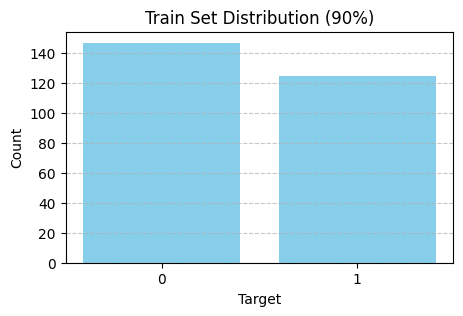

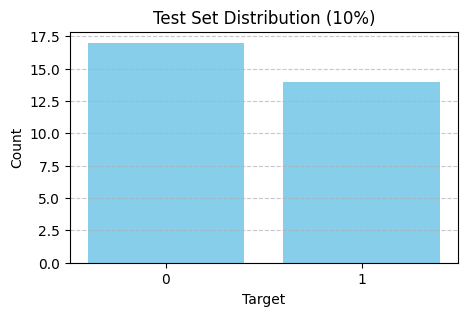

### 📊 Test Size 0.1 Classification Report

              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.57      0.86      0.69        14

    accuracy                           0.65        31
   macro avg       0.69      0.66      0.64        31
weighted avg       0.70      0.65      0.63        31



### 🔍 Test Size 0.1 Confusion Matrix

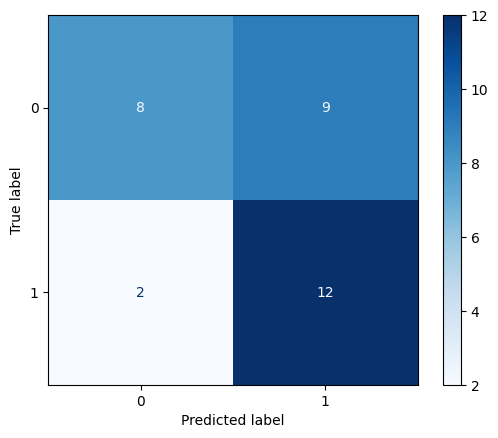

### 🌳 Test Size 0.1 Decision Tree Visualization (matplotlib)

Creating feature names from sample data...


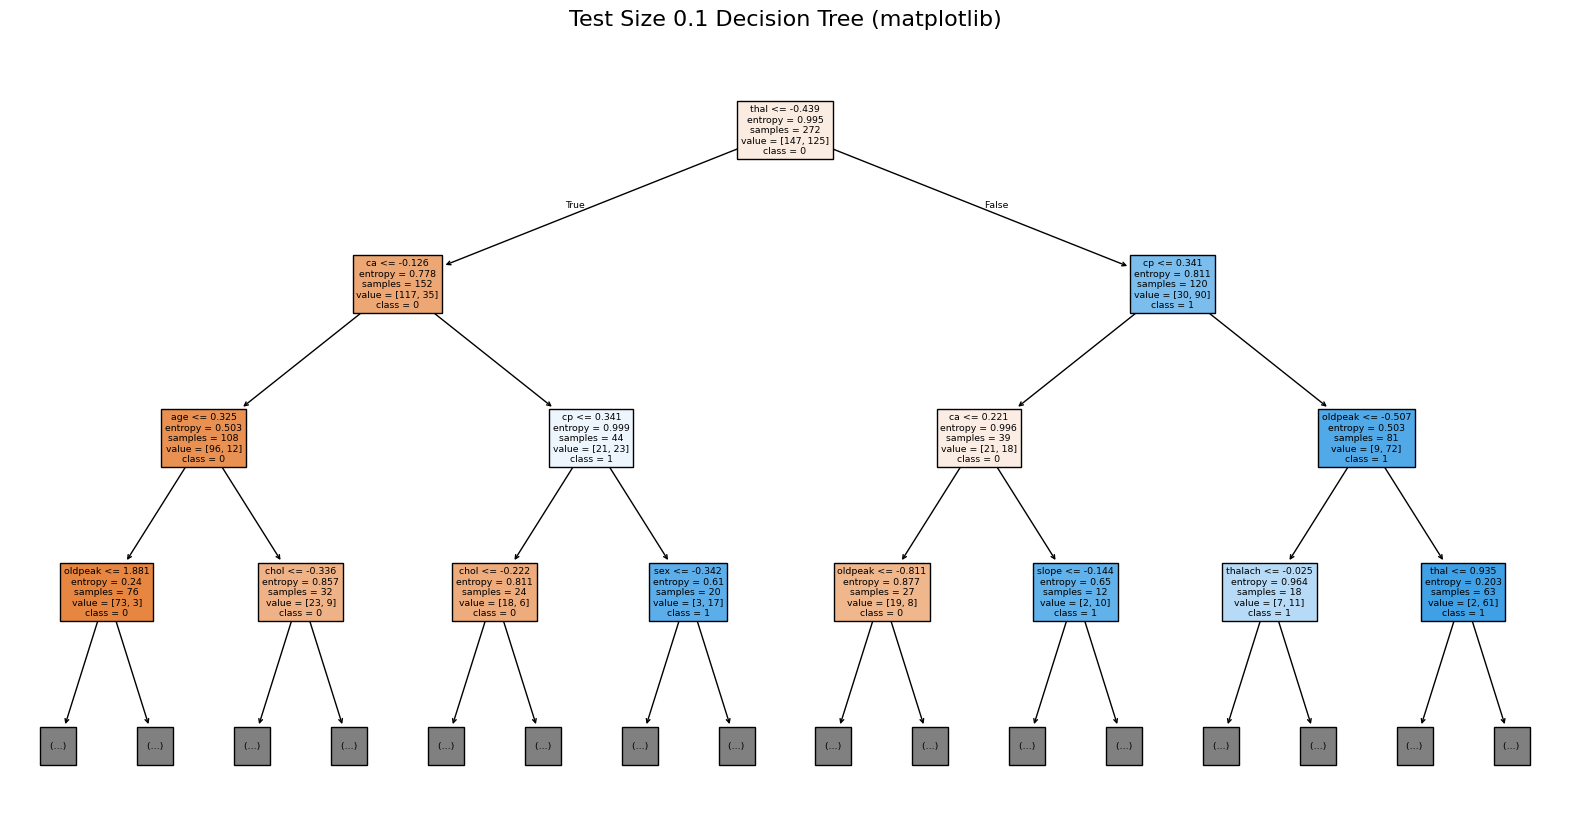

### 🌐 Test Size 0.1 Decision Tree (Graphviz)


(process:4016): Pango-CRITICAL **: 03:53:37.594: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4016): Pango-CRITICAL **: 03:53:37.594: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4016): Pango-CRITICAL **: 03:53:37.594: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4016): Pango-CRITICAL **: 03:53:37.594: pango_font_description_get_family: assertion 'desc != NULL' failed


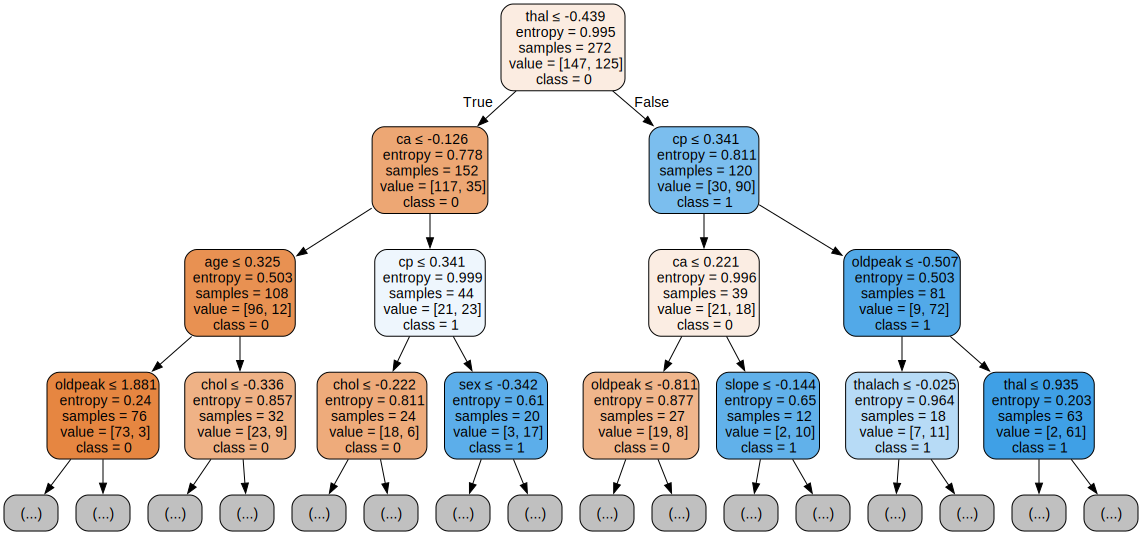

## 🧪 Test Size: 0.2

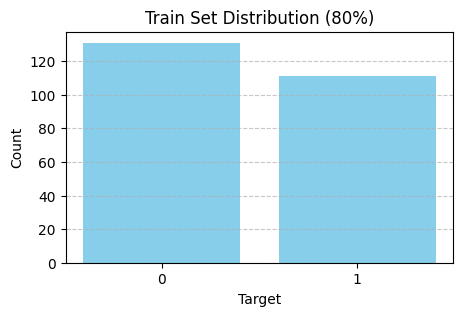

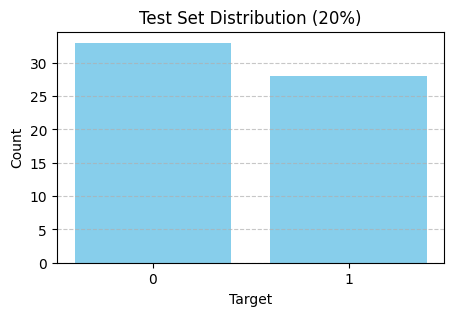

### 📊 Test Size 0.2 Classification Report

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        33
           1       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61



### 🔍 Test Size 0.2 Confusion Matrix

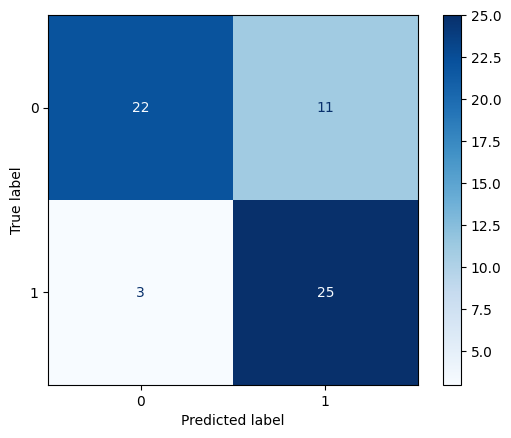

### 🌳 Test Size 0.2 Decision Tree Visualization (matplotlib)

Creating feature names from sample data...


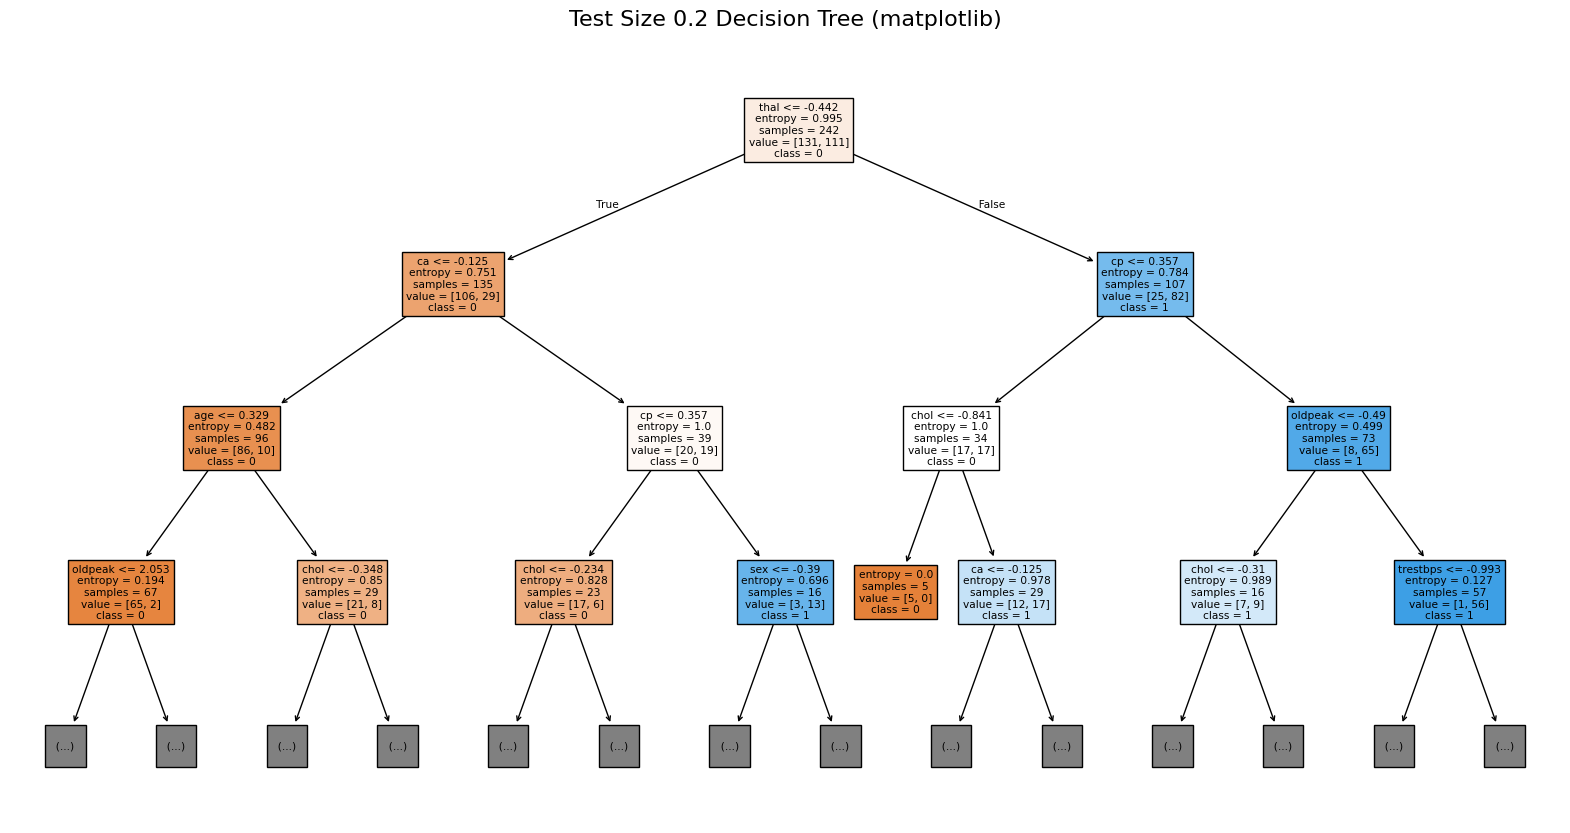

### 🌐 Test Size 0.2 Decision Tree (Graphviz)


(process:4428): Pango-CRITICAL **: 03:53:38.781: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4428): Pango-CRITICAL **: 03:53:38.781: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4428): Pango-CRITICAL **: 03:53:38.781: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4428): Pango-CRITICAL **: 03:53:38.781: pango_font_description_get_family: assertion 'desc != NULL' failed


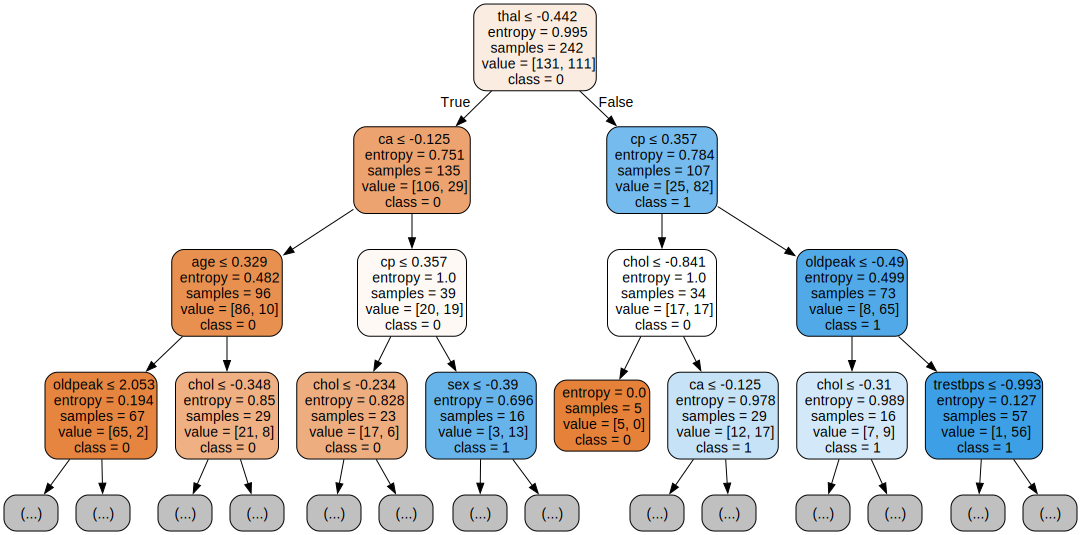

## 🧪 Test Size: 0.4

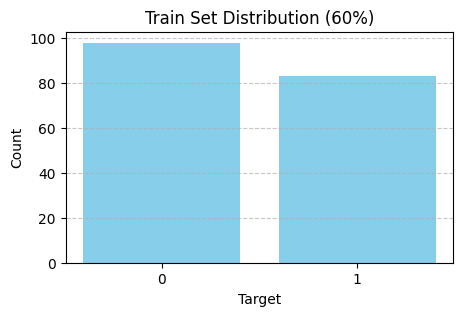

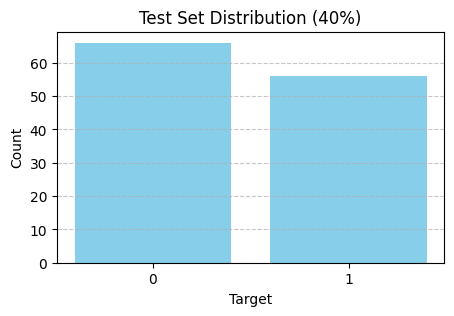

### 📊 Test Size 0.4 Classification Report

              precision    recall  f1-score   support

           0       0.80      0.68      0.74        66
           1       0.68      0.80      0.74        56

    accuracy                           0.74       122
   macro avg       0.74      0.74      0.74       122
weighted avg       0.75      0.74      0.74       122



### 🔍 Test Size 0.4 Confusion Matrix

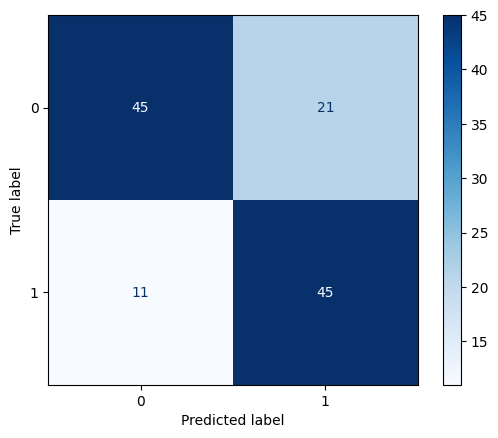

### 🌳 Test Size 0.4 Decision Tree Visualization (matplotlib)

Creating feature names from sample data...


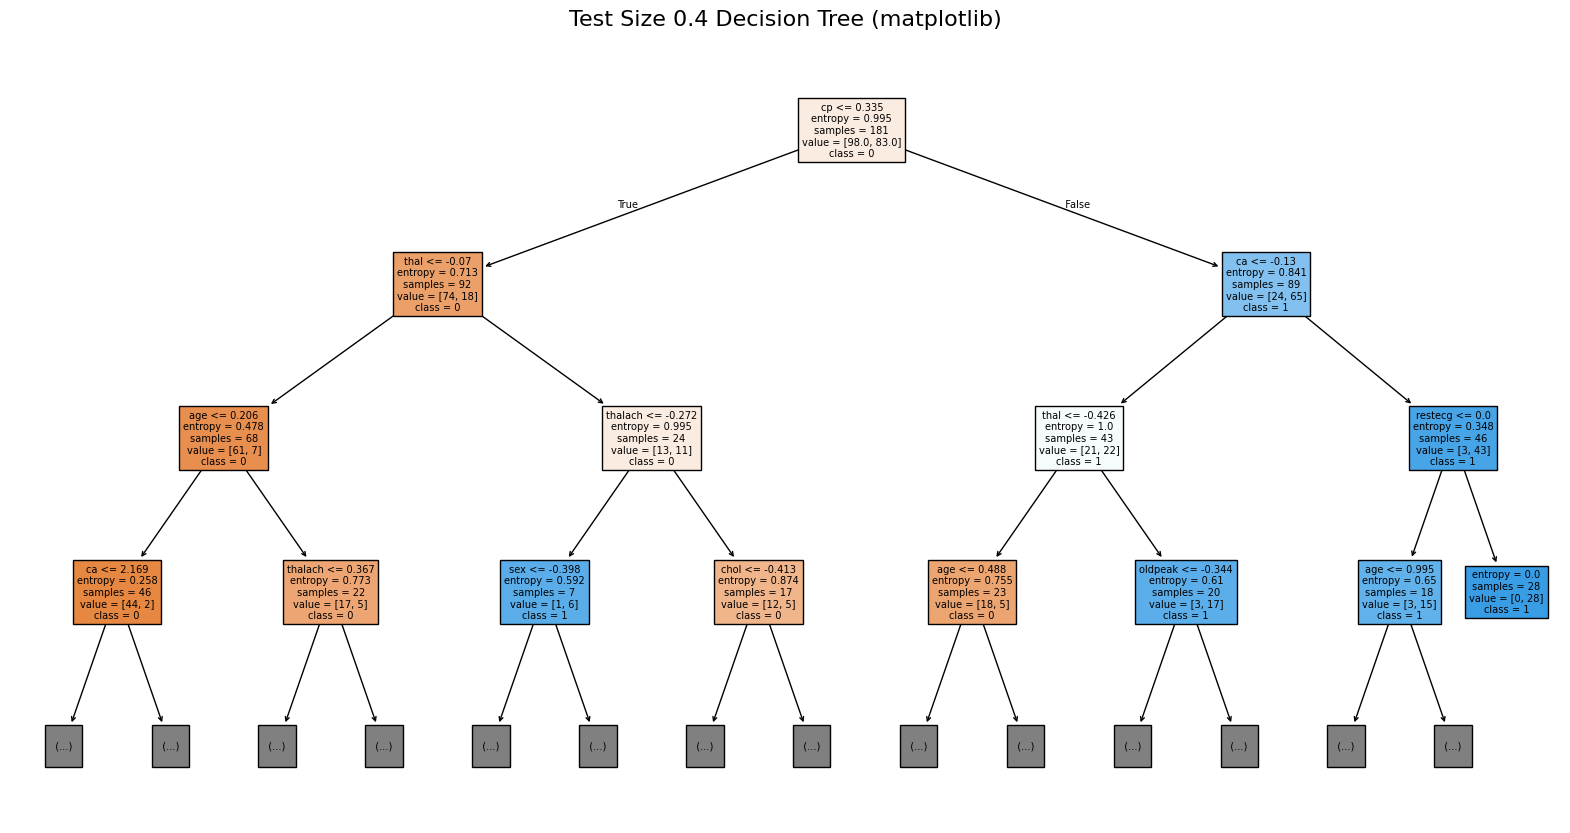

### 🌐 Test Size 0.4 Decision Tree (Graphviz)


(process:20796): Pango-CRITICAL **: 03:53:40.093: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20796): Pango-CRITICAL **: 03:53:40.093: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20796): Pango-CRITICAL **: 03:53:40.093: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20796): Pango-CRITICAL **: 03:53:40.093: pango_font_description_get_family: assertion 'desc != NULL' failed


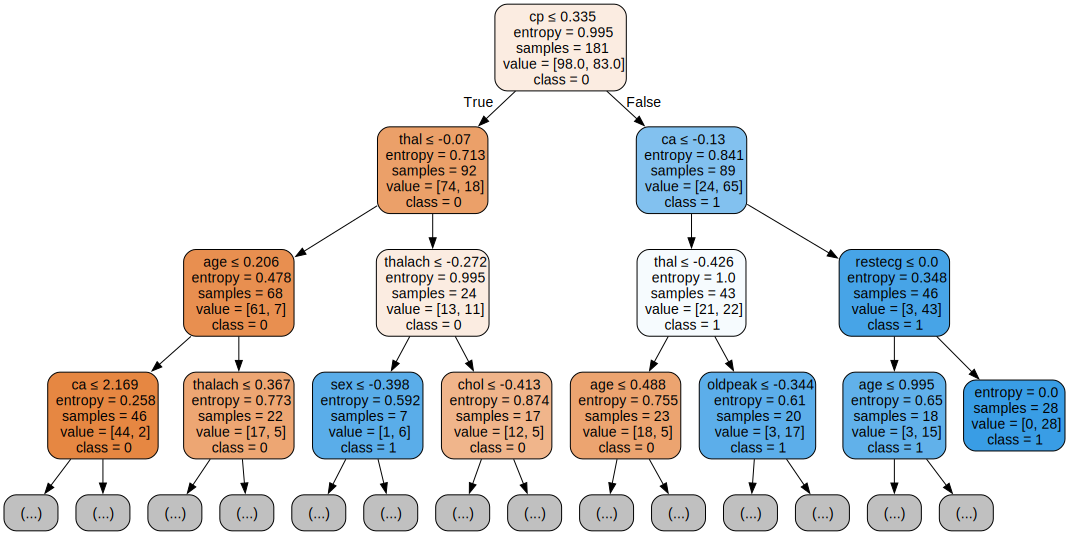

## 🧪 Test Size: 0.6

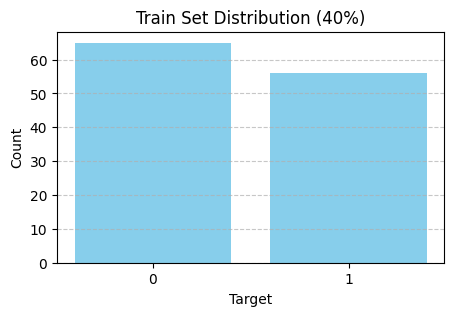

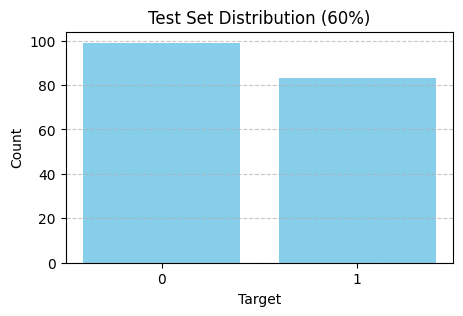

### 📊 Test Size 0.6 Classification Report

              precision    recall  f1-score   support

           0       0.80      0.68      0.73        99
           1       0.67      0.80      0.73        83

    accuracy                           0.73       182
   macro avg       0.74      0.74      0.73       182
weighted avg       0.74      0.73      0.73       182



### 🔍 Test Size 0.6 Confusion Matrix

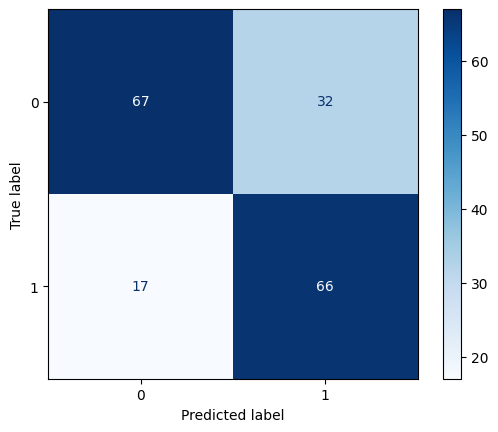

### 🌳 Test Size 0.6 Decision Tree Visualization (matplotlib)

Creating feature names from sample data...


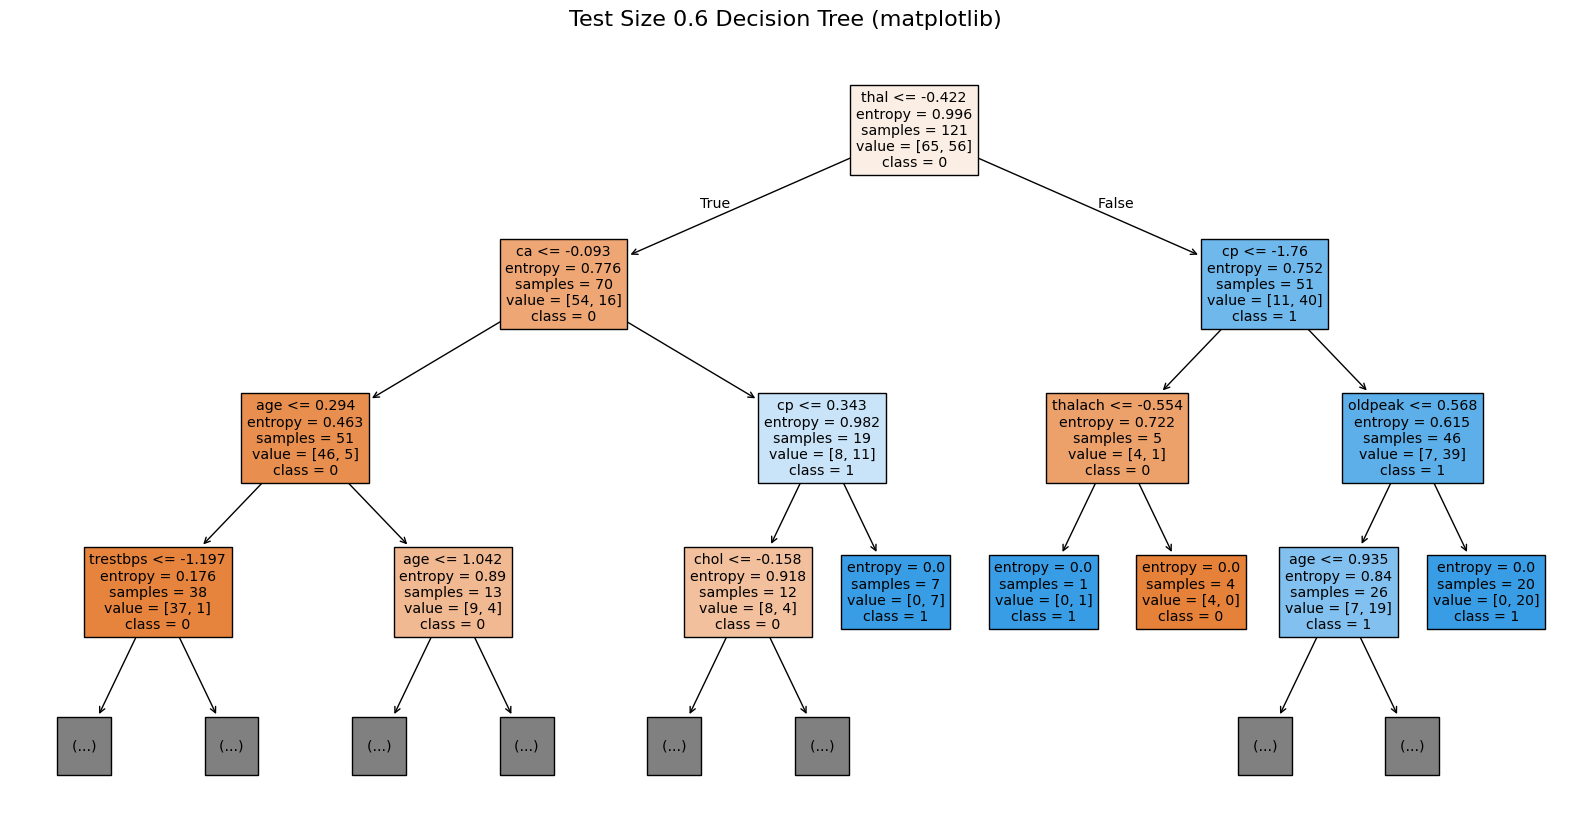

### 🌐 Test Size 0.6 Decision Tree (Graphviz)


(process:20820): Pango-CRITICAL **: 03:53:41.214: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20820): Pango-CRITICAL **: 03:53:41.214: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20820): Pango-CRITICAL **: 03:53:41.214: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:20820): Pango-CRITICAL **: 03:53:41.214: pango_font_description_get_family: assertion 'desc != NULL' failed


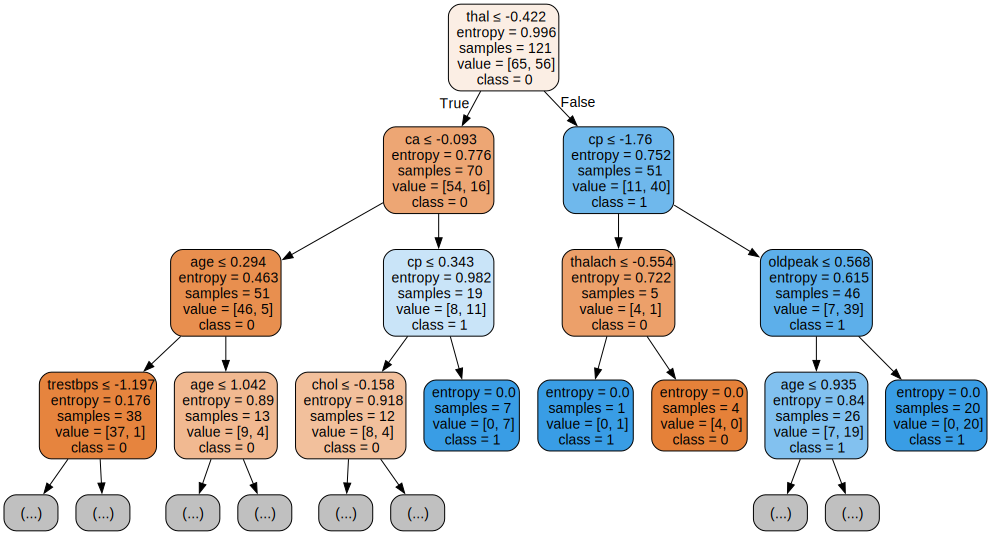

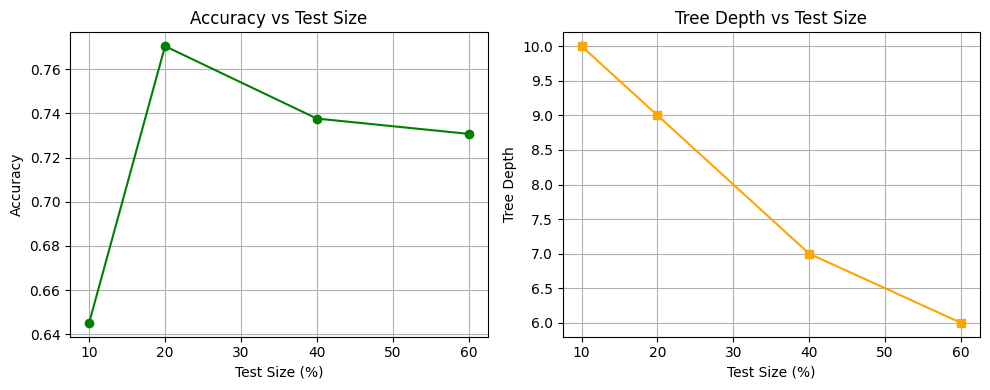

([Pipeline(steps=[('preprocess',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer()),
                                                                    ('scaler',
                                                                     StandardScaler())]),
                                                    Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
         'exang', 'oldpeak', 'slope', 'ca', 'thal'],
        dtype='object')),
                                                   ('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('encoder',
                                   

In [212]:
df = load_data()
run_experiments(df)

# Optional: Uncomment to try max_depth analysis
# max_depth_experiment(df)